# Iman Conover and Rearragement

And analysis of different copulas

## Provenance

* From UsingSamples (extracted)
* New, Sept 26, 2022 (Loudoun Road!) 

In [1]:
import aggregate as agg
from aggregate import build
import scipy.stats as ss
from pandas.plotting import scatter_matrix
import samples as sam

time: 767 ms


Parser debugging for UnderwritingParser written to C:\Users\steve\aggregate\parser\parser.out


line_0    line_1    line_2
line_0     1.000 -469.624m   24.123m
line_1 -469.624m     1.000 -450.624m
line_2   24.123m -450.624m     1.000

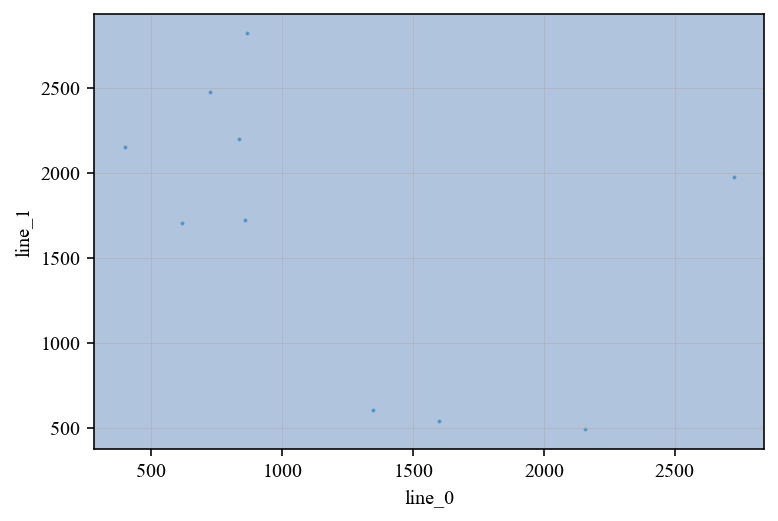

time: 238 ms


In [2]:
# make a test df
n = 10
# random sample
df = pd.DataFrame({ f'line_{i}': ss.lognorm(0.5 + 0.2*np.random.rand(),
                    scale=1000).rvs(n) for i in range(3)})

df.plot(kind='scatter', x='line_0', y='line_1', marker='.', s=4, alpha=.5).grid(lw=.3)
df.corr()

In [3]:
desired = np.matrix([[1, -.3, -.45], [-.3, 1, .8], [-.45, .8, 1]])
# check it is a corr matrix
print(desired, '\n\n', np.linalg.cholesky(desired))


[[         1       -0.3      -0.45]
 [      -0.3          1        0.8]
 [     -0.45        0.8          1]] 

 [[         1          0          0]
 [      -0.3    0.95394          0]
 [     -0.45    0.69711    0.55816]]
time: 2.89 ms


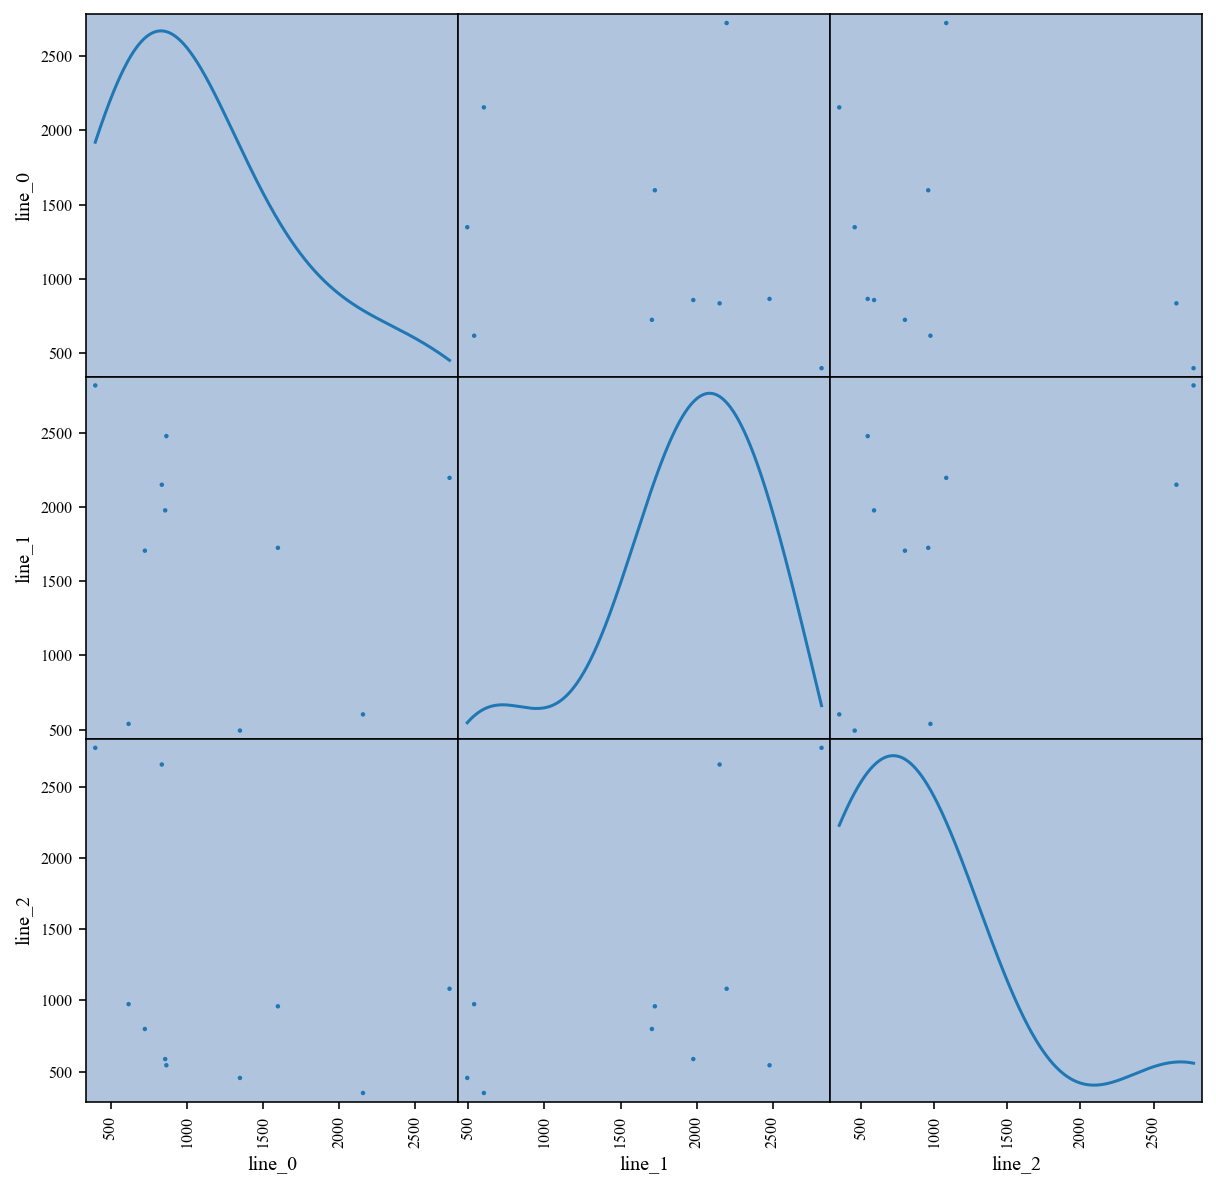

time: 448 ms


In [4]:
df2 = agg.iman_conover(df, desired)
df2.corr()
scatter_matrix(df2, marker='.', s=20, alpha=1, figsize=(10, 10), diagonal='kde');


In [5]:
test = pd.DataFrame({f'x{i}': range(10) for i in range(5)})
test


x0  x1  x2  x3  x4
0   0   0   0   0   0
1   1   1   1   1   1
2   2   2   2   2   2
3   3   3   3   3   3
4   4   4   4   4   4
5   5   5   5   5   5
6   6   6   6   6   6
7   7   7   7   7   7
8   8   8   8   8   8
9   9   9   9   9   9

time: 8.36 ms


In [6]:
agg.rearrangement_algorithm_max_VaR(test, p=0, tau=1e-3, max_n_iter=100)

Iteration 2	2.200e+01	Chg	0.000e+00
Ending VaR	2.20000e+01
s lower 2.20000e+01


x0  x1  x2  x3  x4  total
4   3   5   4   6   4     22
6   7   7   5   0   3     22
7   5   6   8   3   0     22
8   2   4   3   5   8     22
9   4   1   9   7   1     22
0   9   9   1   2   2     23
1   1   2   2   9   9     23
2   6   0   6   4   7     23
3   0   3   7   8   5     23
5   8   8   0   1   6     23

time: 30.7 ms


In [7]:
# apply to simple dataframe of 100 rows, look at 90 percentile (tenth highest)
n = 100
df = pd.DataFrame({ f'line_{i}': ss.lognorm(s,
                    scale=10000).rvs(n) for s, i in zip([.3, .7, 1.], range(3))})
df['total'] = df.sum(axis=1)
df = df.sort_values('total').reset_index(drop=True)
display(df.describe([.1, .5, .9]))
df.tail(10)


line_0   line_1    line_2     total
count  100.000  100.000   100.000   100.000
mean   10.548k  11.728k   15.391k   37.667k
std     3.197k   8.190k   17.825k   20.541k
min     4.585k   1.665k    1.059k   11.924k
10%     7.322k   3.410k    3.564k   20.226k
50%     9.905k  10.003k    9.703k   32.727k
90%    14.283k  22.844k   30.795k   56.675k
max    20.575k  51.435k  118.219k  138.654k

line_0   line_1    line_2     total
90   7.681k  20.263k   29.690k   57.633k
91   9.190k  24.877k   30.697k   64.763k
92  16.432k  18.379k   35.714k   70.525k
93  13.961k   4.214k   53.786k   71.961k
94   8.530k  12.430k   53.516k   74.476k
95  12.198k  51.435k   16.481k   80.114k
96  10.098k   5.551k   66.375k   82.024k
97   8.339k  20.142k   69.111k   97.591k
98  10.803k  35.237k   80.297k  126.338k
99  10.803k   9.631k  118.219k  138.654k

time: 30.2 ms


In [8]:
out = agg.rearrangement_algorithm_max_VaR(df.filter(regex='line'), p=.90, tau=1e-3, max_n_iter=100)
out

Iteration 2	8.591e+04	Chg	-3.097e+03
Iteration 3	8.613e+04	Chg	-2.173e+02
Iteration 4	8.613e+04	Chg	0.000e+00
Ending VaR	8.61322e+04
s lower 8.61322e+04


line_0   line_1    line_2     total
1  18.930k  35.237k   31.966k   86.132k
3  20.575k  30.300k   35.714k   86.589k
5  19.901k  25.905k   41.012k   86.818k
2  16.432k  25.082k   53.786k   95.300k
8  16.929k  24.877k   53.516k   95.322k
0  15.795k  51.435k   31.679k   98.909k
9  15.344k  23.790k   66.375k  105.509k
7  15.086k  23.753k   69.111k  107.950k
4  14.828k  23.725k   80.297k  118.851k
6  14.638k  23.217k  118.219k  156.074k

time: 31.8 ms


In [9]:
# highest possible uniform var is comonotonic ordering
dfc = df.copy().drop(columns='total')
for c in dfc.columns:
    dfc[c] = dfc[c].sort_values().values
dfc['total'] = dfc.sum(axis=1)
dfc = dfc.sort_values('total').reset_index(drop=True)
dfc.tail(10)


line_0   line_1    line_2     total
90  14.638k  23.217k   31.679k   69.534k
91  14.828k  23.725k   31.966k   70.519k
92  15.086k  23.753k   35.714k   74.553k
93  15.344k  23.790k   41.012k   80.146k
94  15.795k  24.877k   53.516k   94.188k
95  16.432k  25.082k   53.786k   95.300k
96  16.929k  25.905k   66.375k  109.209k
97  18.930k  30.300k   69.111k  118.341k
98  19.901k  35.237k   80.297k  135.435k
99  20.575k  51.435k  118.219k  190.229k

time: 11.8 ms


In [10]:
comp = pd.concat([i.reset_index(drop=True) for i in [df.tail(10), dfc.tail(10), out]],
          axis=1,
          keys=['indep', 'comon', 'ra'],
          names=['kind', 'line'])
comp.iloc[:, 3::4]


kind     indep     comon        ra
line     total     total     total
0      57.633k   69.534k   86.132k
1      64.763k   70.519k   86.589k
2      70.525k   74.553k   86.818k
3      71.961k   80.146k   95.300k
4      74.476k   94.188k   95.322k
5      80.114k   95.300k   98.909k
6      82.024k  109.209k  105.509k
7      97.591k  118.341k  107.950k
8     126.338k  135.435k  118.851k
9     138.654k  190.229k  156.074k

time: 14.6 ms


<AxesSubplot:>

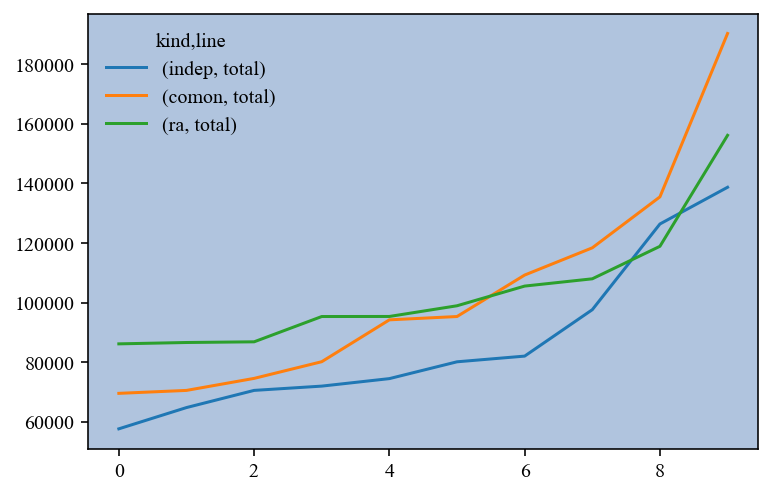

time: 182 ms


In [11]:
comp.iloc[:, 3::4].plot()

In [17]:
res.sample

total        A        B        C        D        E        F        G  \
0     330.186   81.964   65.022   50.827   53.807   32.666   22.988   19.639   
1     333.760   73.452   62.982   51.840   52.350   41.620   21.990   27.757   
2     336.858   73.956   73.555   45.921   50.866   35.637   34.686   18.657   
3     343.378   77.061   66.842   48.738   51.603   41.672   30.547   24.507   
4     345.778   87.042   59.912   51.470   54.292   36.276   36.402   14.149   
...       ...      ...      ...      ...      ...      ...      ...      ...   
9995   2.048k  128.473  127.253  170.974  170.924  218.190  338.048  317.927   
9996   2.078k  119.840  159.352  185.558  171.140  269.440  364.433  370.382   
9997   2.086k  134.837  106.937  193.137  205.720  263.983  217.375  408.022   
9998   2.128k  134.137  120.988  198.137  251.995  269.738  293.198  491.599   
9999   2.201k  124.825  162.049  167.270  165.671  197.313  397.908  221.962   

            H  
0       3.272  
1       1.769  
2       3.581  
3       2.408  
4       6.235  
...       ...  
9995  576.524  
9996  438.026  
9997  555.662  
9998  368.285  
9999  764.310  

[10000 rows x 9 columns]

time: 29 ms


In [18]:
res.port

<aggregate.port.Portfolio object at 0x00000288E000CEB0>, { 'name': 'test', 'spec': [{'name': 'A', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'B', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'C', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'D', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'E', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'F', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'G', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'H', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}], "bs": 1, "log2": 13, "padding": 1, "tilt_amount": 0, "distortion": "None", "sev_calc": "discrete", "remove_fuzz": True, "approx_type": "slognorm", "approx_freq_ge": 100}

time: 13.9 ms


In [21]:
port2 = agg.Portfolio('FromSample', res.sample)

12:47.984| 216|INFO      | aggregate.port, __init__|  NEW DATAFRAME INPUT!


time: 116 ms


In [22]:
port2.update(13, 1, remove_fuzz=True)
port2

12:49.054|2193|INFO      | aggregate.port, add_exa|  Portfolio.add_exa | FromSample: sum of p_total is 1 - 4.99600361e-15 NOT RESCALING
12:49.056|2209|INFO      | aggregate.port, add_exa|  Portfolio.add_exa | FromSample: S <= 0 values has length 5855


Non-Portfolio (enhanced) object { "name": "FromSample", 'spec': [{'name': 'A', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'B', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'C', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'D', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'E', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'F', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'G', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'H', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}], "bs": 1, "log2": 13, "padding": 1, "tilt_amount": 0, "distortion": "None", "sev_calc": "discrete", "remove_fuzz": True, "approx_type": "slognorm", "approx_freq_ge": 100}

time: 508 ms


In [94]:
res.port

Non-Portfolio (enhanced) object { "name": "test", 'spec': [{'name': 'A', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'B', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'C', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'D', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'E', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'F', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'G', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}, {'name': 'H', 'note': '', 'occ_reins': None, 'occ_kind': '', 'agg_reins': None, 'agg_kind': ''}], "bs": 1, "log2": 13, "padding": 1, "tilt_amount": 0, "distortion": "None", "sev_calc": "discrete", "remove_fuzz": True, "approx_type": "slognorm", "approx_freq_ge": 100}

time: 15 ms (started: 2022-09-26 21:50:34 +01:00)


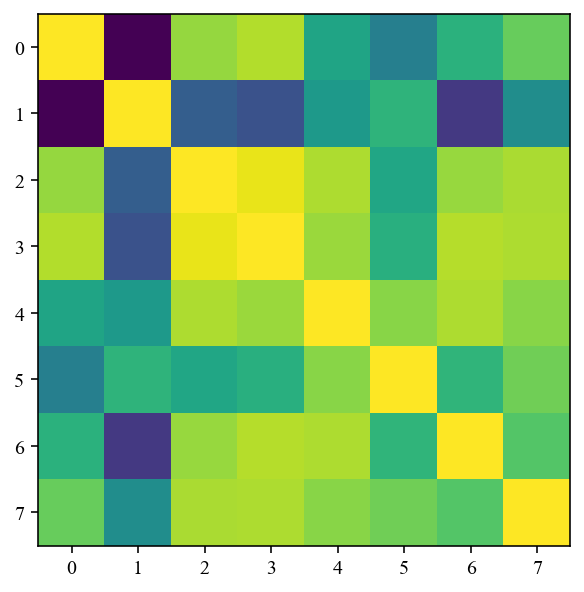

time: 189 ms


In [25]:
%%sf 1 1 4 4 
ax.imshow(res.rcm)

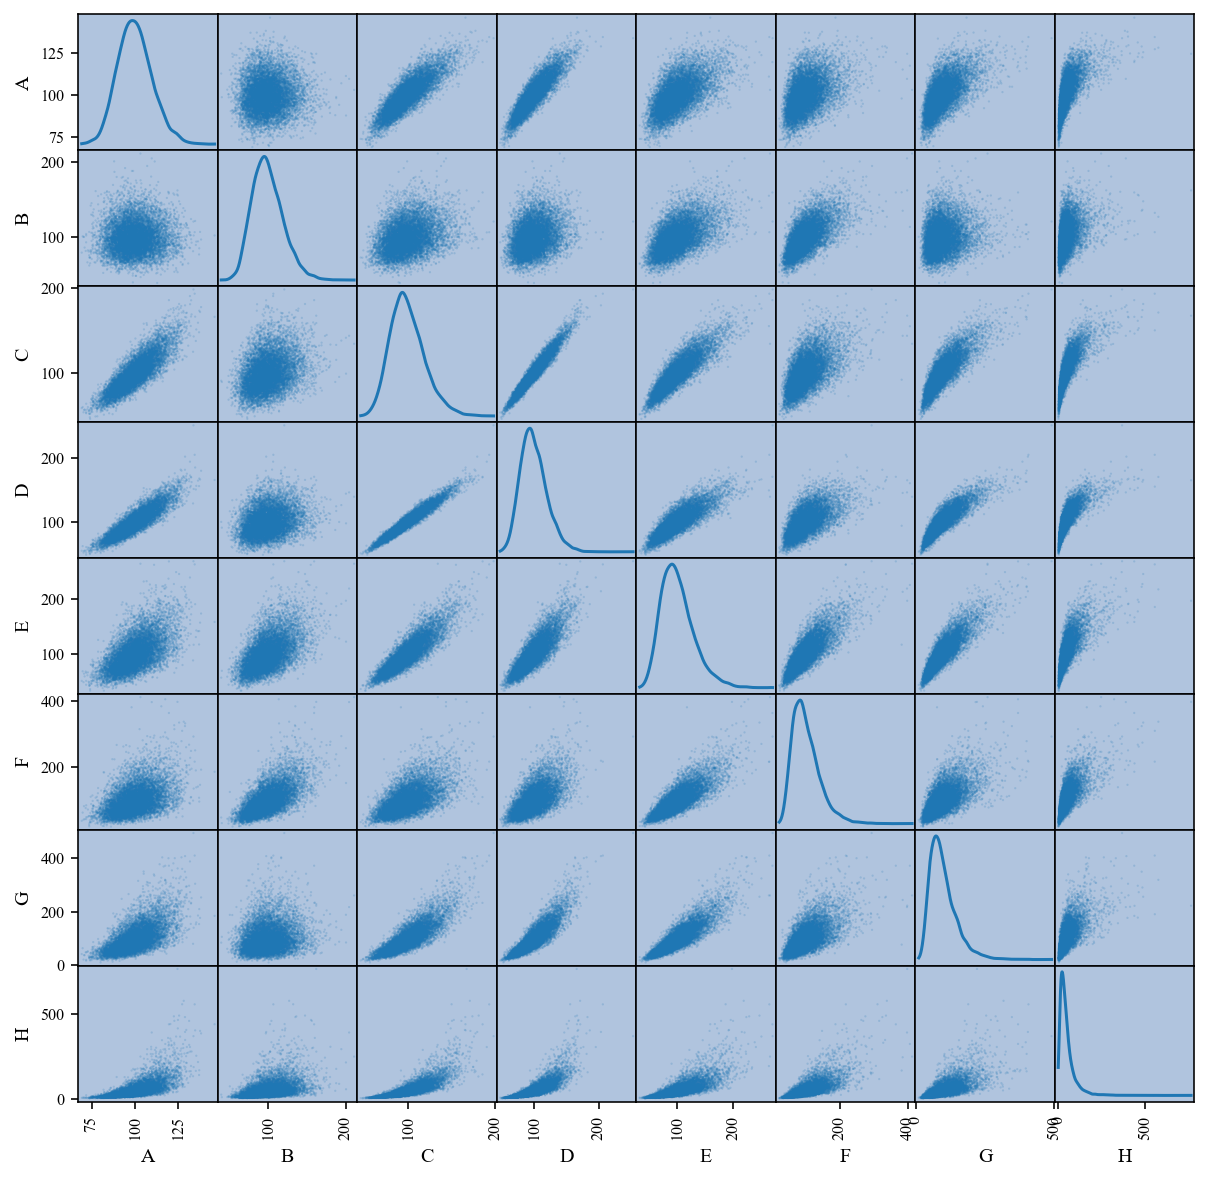

time: 5.6 s


In [26]:
scatter_matrix(res.sample.iloc[:, 1:], marker='.', s=5, alpha=.2, figsize=(10, 10), diagonal='kde');

In [27]:
res.sample

total        A        B        C        D        E        F        G  \
0     330.186   81.964   65.022   50.827   53.807   32.666   22.988   19.639   
1     333.760   73.452   62.982   51.840   52.350   41.620   21.990   27.757   
2     336.858   73.956   73.555   45.921   50.866   35.637   34.686   18.657   
3     343.378   77.061   66.842   48.738   51.603   41.672   30.547   24.507   
4     345.778   87.042   59.912   51.470   54.292   36.276   36.402   14.149   
...       ...      ...      ...      ...      ...      ...      ...      ...   
9995   2.048k  128.473  127.253  170.974  170.924  218.190  338.048  317.927   
9996   2.078k  119.840  159.352  185.558  171.140  269.440  364.433  370.382   
9997   2.086k  134.837  106.937  193.137  205.720  263.983  217.375  408.022   
9998   2.128k  134.137  120.988  198.137  251.995  269.738  293.198  491.599   
9999   2.201k  124.825  162.049  167.270  165.671  197.313  397.908  221.962   

            H  
0       3.272  
1       1.769  
2       3.581  
3       2.408  
4       6.235  
...       ...  
9995  576.524  
9996  438.026  
9997  555.662  
9998  368.285  
9999  764.310  

[10000 rows x 9 columns]

time: 16.1 ms


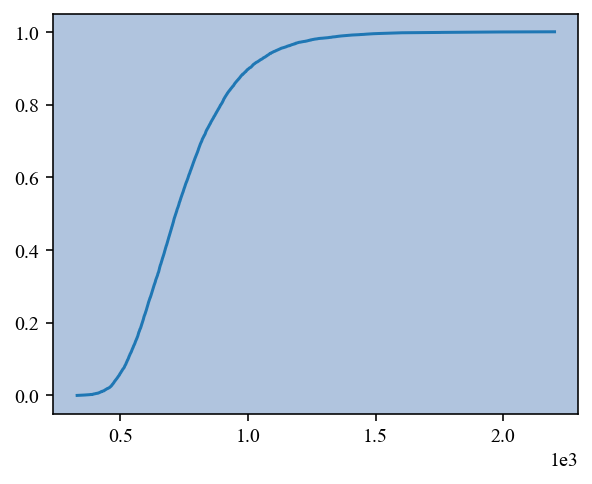

time: 267 ms


In [30]:
%%sf 1 1 



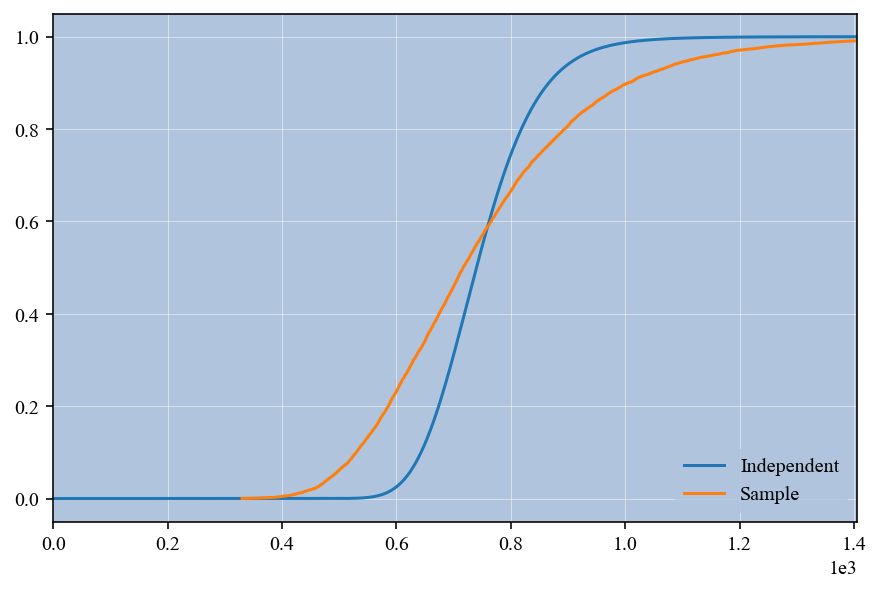

time: 167 ms


In [33]:
%%sf  1 1 6 4
res.port.density_df.F.plot(ax=ax, label='Independent')
ax.plot(res.sample.total, np.linspace(0,1,len(res.sample)), label='Sample')
ax.grid(lw=.25, c='w')
ax.set(xlim=[0, res.port.q(.9999)])
ax.legend(loc='lower right')

In [36]:
res.df_exa.head().T

0.000      1.000      2.000      3.000      4.000
loss              0.000      1.000      2.000      3.000      4.000
p_A               0.000      0.000      0.000      0.000      0.000
p_B               0.000      0.000      0.000      0.000      0.000
p_C               0.000      0.000      0.000      0.000      0.000
p_D               0.000      0.000      0.000      0.000      0.000
p_E               0.000      0.000      0.000      0.000      0.000
p_F               0.000      0.000      0.000      0.000      0.000
p_G               0.000      0.000      0.000      0.000      0.000
p_H               0.000      0.000   201.595u   705.584u     2.318m
exa_total         0.000  1000.000m      2.000      3.000      4.000
exlea_total         NaN      0.000      0.000      0.000      0.000
e_total         750.073    750.073    750.073    750.073    750.073
exgta_total     750.073    750.073    750.073    750.073    750.073
exeqa_total       0.000      1.000      2.000      3.000      4.000
e_A             100.060    100.060    100.060    100.060    100.060
e_B              99.844     99.844     99.844     99.844     99.844
e_C              99.574     99.574     99.574     99.574     99.574
e_D             100.021    100.021    100.021    100.021    100.021
e_E             100.463    100.463    100.463    100.463    100.463
e_F             100.624    100.624    100.624    100.624    100.624
e_G              99.134     99.134     99.134     99.134     99.134
e_H              50.354     50.354     50.354     50.354     50.354
p_total           0.000      0.000      0.000      0.000      0.000
F                 0.000      0.000      0.000      0.000      0.000
S             1000.000m  1000.000m  1000.000m  1000.000m  1000.000m
exeqa_A           0.000      0.000      0.000      0.000      0.000
exeqa_B           0.000      0.000      0.000      0.000      0.000
exeqa_C           0.000      0.000      0.000      0.000      0.000
exeqa_D           0.000      0.000      0.000      0.000      0.000
exeqa_E           0.000      0.000      0.000      0.000      0.000
exeqa_F           0.000      0.000      0.000      0.000      0.000
exeqa_G           0.000      0.000      0.000      0.000      0.000
exeqa_H           0.000      0.000      0.000      0.000      0.000
lev_A             0.000      1.000      2.000      3.000      4.000
exlea_A           0.000        NaN        NaN        NaN        NaN
exgta_A         100.060    100.060    100.060    100.060    100.060
exi_x_A        139.738m   139.738m   139.738m   139.738m   139.738m
exi_xlea_A        0.000      0.000      0.000      0.000      0.000
exi_xgta_A     139.738m   139.738m   139.738m   139.738m   139.738m
exi_xeqa_A        0.000      0.000      0.000      0.000      0.000
exa_A             0.000   139.738m   279.476m   419.214m   558.952m
lev_B             0.000      1.000      2.000      3.000      4.000
exlea_B           0.000        NaN        NaN        NaN        NaN
exgta_B          99.844     99.844     99.844     99.844     99.844
exi_x_B        138.194m   138.194m   138.194m   138.194m   138.194m
exi_xlea_B        0.000      0.000      0.000      0.000      0.000
exi_xgta_B     138.194m   138.194m   138.194m   138.194m   138.194m
exi_xeqa_B        0.000      0.000      0.000      0.000      0.000
exa_B             0.000   138.194m   276.389m   414.583m   552.777m
lev_C             0.000      1.000      2.000      3.000      4.000
exlea_C           0.000        NaN        NaN        NaN        NaN
exgta_C          99.574     99.574     99.574     99.574     99.574
exi_x_C        135.352m   135.352m   135.352m   135.352m   135.352m
exi_xlea_C        0.000      0.000      0.000      0.000      0.000
exi_xgta_C     135.352m   135.352m   135.352m   135.352m   135.352m
exi_xeqa_C        0.000      0.000      0.000      0.000      0.000
exa_C             0.000   135.352m   270.704m   406.056m   541.408m
lev_D             0.000      1.000      2.000      3.000      4.000
exlea_

time: 36 ms


In [34]:
res.df_exa[['loss', 'p_A', 'p_total', 'exeqa_A', 'exeqa_B', 'exeqa_C', 'exeqa_total', 'S', 'F']].query('p_total > 0')

loss    p_A   p_total  exeqa_A  exeqa_B  exeqa_C  exeqa_total  \
331.000  331.000  0.000  100.000u   82.000   65.000   51.000      331.000   
334.000  334.000  0.000  100.000u   73.000   63.000   52.000      334.000   
339.000  339.000  0.000  100.000u   74.000   74.000   46.000      339.000   
344.000  344.000  0.000  100.000u   87.000   60.000   51.000      344.000   
345.000  345.000  0.000  100.000u   77.000   67.000   49.000      345.000   
...          ...    ...       ...      ...      ...      ...          ...   
2.048k    2.048k  0.000  100.000u  128.000  127.000  171.000       2.048k   
2.077k    2.077k  0.000  100.000u  120.000  159.000  186.000       2.077k   
2.086k    2.086k  0.000  100.000u  135.000  107.000  193.000       2.086k   
2.128k    2.128k  0.000  100.000u  134.000  121.000  198.000       2.128k   
2.201k    2.201k  0.000  100.000u  125.000  162.000  167.000       2.201k   

                S          F  
331.000  999.900m   100.000u  
334.000  999.800m   200.000u  
339.000  999.700m   300.000u  
344.000  999.600m   400.000u  
345.000  999.500m   500.000u  
...           ...        ...  
2.048k   400.000u   999.600m  
2.077k   300.000u   999.700m  
2.086k   200.000u   999.800m  
2.128k   100.000u   999.900m  
2.201k      0.000  1000.000m  

[1031 rows x 9 columns]

time: 21.5 ms


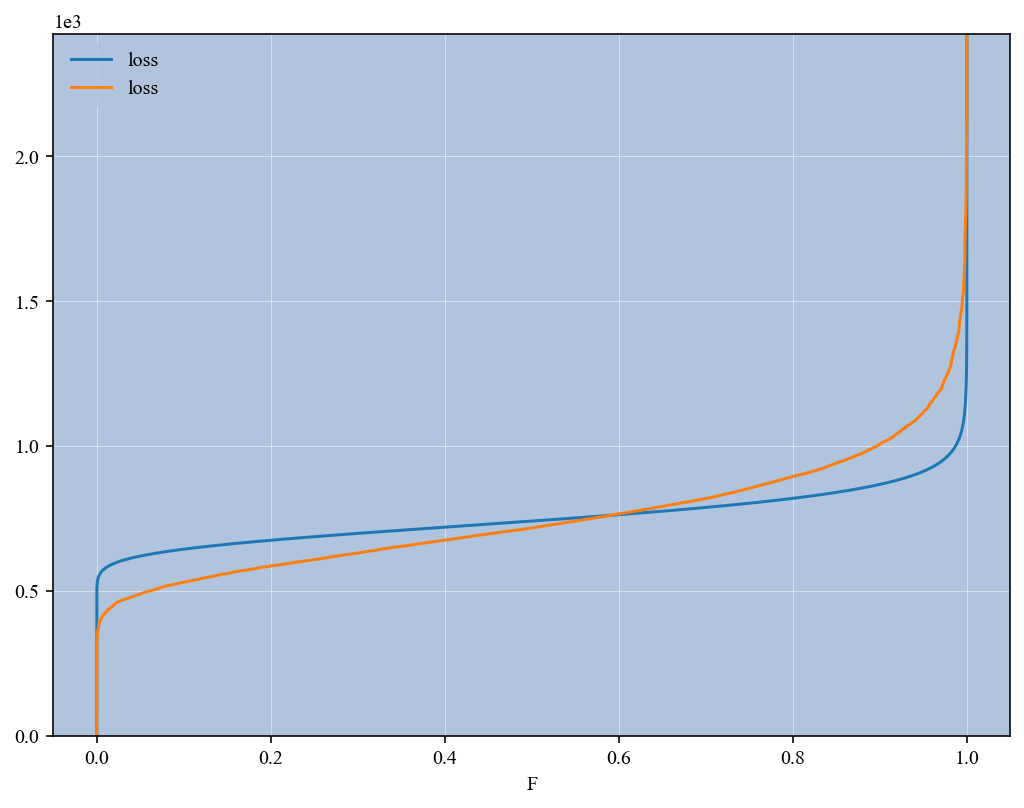

time: 215 ms


In [37]:
%%sf 1 1 7 5.5

res.port.density_df.set_index('F')[['loss']].plot(ax=ax, label='Independent')

res.df_exa.set_index('F')[['loss']].plot(ax=ax, label='Sample')

ax.legend()
ax.grid(lw=.25, c='w')
ax.set(ylim=[0, res.sample.total.max()* 1.1])

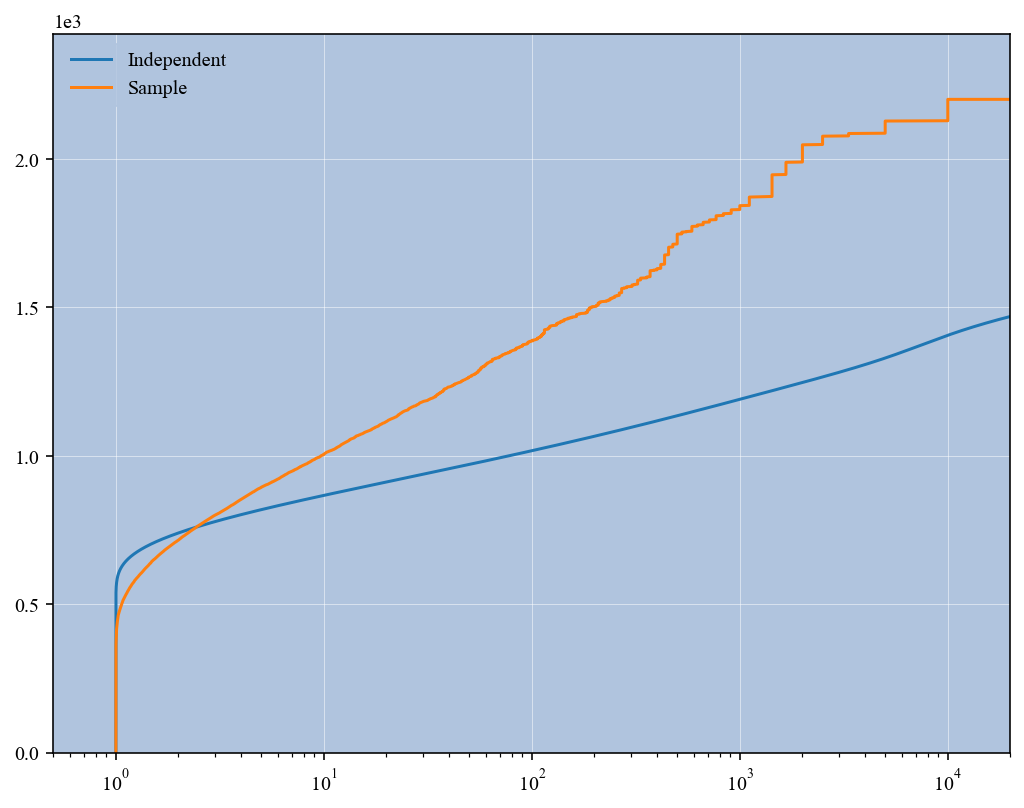

time: 551 ms


In [38]:
%%sf 1 1 7 5.5

rp = 1 / (1 - np.minimum(1, res.port.density_df.F))

ax.plot(rp, res.port.density_df.loss, label='Independent')

rp = 1 / (1 - np.minimum(1, res.df_exa.F))
ax.plot(rp, res.df_exa.loss, label='Sample')

ax.set(xscale='log', xlim=[.5, 20000], ylim=[0, res.sample.total.max() * 1.1]) 
ax.legend()
ax.grid(lw=.25, c='w')

In [39]:
res.port.calibrate_distortions(ROEs=[.125], Ps=[.99], df=[0, .995], strict=False)

$S$   $\iota$  $\delta$     $\nu$     $EL$  \
$a$    LR       method                                                   
1.017k 961.825m ph       9.973m  125.000m  111.111m  888.889m  749.329   
                wang     9.973m  125.000m  111.111m  888.889m  749.329   
                cll      9.973m  125.000m  111.111m  888.889m  749.329   
                lep      9.973m  125.000m  111.111m  888.889m  749.329   
                ly       9.973m  125.000m  111.111m  888.889m  749.329   
                clin     9.973m  125.000m  111.111m  888.889m  749.329   
                dual     9.973m  125.000m  111.111m  888.889m  749.329   
                ccoc     9.973m  125.000m  111.111m  888.889m  749.329   
                tvar     9.973m  125.000m  111.111m  888.889m  749.329   
                wtdtvar  9.973m  125.000m  111.111m  888.889m  749.329   

                             $P$   Levg      $K$       ROE     param     error  
$a$    LR       method                                                          
1.017k 961.825m ph       779.071  3.274  237.929  125.000m  718.677m    2.375n  
                wang     779.071  3.274  237.929  125.000m  329.299m    1.923n  
                cll      779.071  3.274  237.929  125.000m  762.753m   46.043p  
                lep      779.071  3.274  237.929  125.000m  236.592m   -1.921u  
                ly       779.071  3.274  237.929  125.000m  581.807m -154.273p  
                clin     779.071  3.274  237.929  125.000m     1.149 -113.687f  
                dual     779.071  3.274  237.929  125.000m     1.507 -102.887p  
                ccoc     779.071  3.274  237.929  125.000m  125.000m     0.000  
                tvar     779.071  3.274  237.929  125.000m  212.503m    9.479u  
                wtdtvar  779.071  3.274  237.929  125.000m  111.111m -113.687f

time: 83.1 ms


In [45]:
res.port.density_df.sum()

loss             33.550M
p_A                1.000
p_B                1.000
p_C                1.000
p_D                1.000
p_E                1.000
p_F                1.000
p_G                1.000
p_H                1.000
exa_total         5.859M
exlea_total       5.776M
e_total           6.145M
exgta_total          inf
exeqa_total      33.550M
e_A             819.688k
e_B             817.923k
e_C             815.713k
e_D             819.368k
e_E             822.994k
e_F             824.310k
e_G             812.103k
e_H             412.501k
p_total            1.000
F                 7.442k
S                749.756
exeqa_A         107.381k
exeqa_B         108.882k
exeqa_C         114.777k
exeqa_D         115.623k
exeqa_E         124.755k
exeqa_F         131.185k
exeqa_G         138.018k
exeqa_H          94.799k
lev_A           814.581k
exlea_A         780.268k
exgta_A              inf
exi_x_A           1.145k
exi_xlea_A        1.110k
exi_xgta_A       215.662
exi_xeqa_A       131.999


time: 16.3 ms


In [40]:
ans0 = res.port.apply_distortions(res.port.dists, Ps=[0.99], num_plots=0, efficient=True)

19:45.164|3013|INFO      | aggregate.port, apply_distortion|  Index of ess_sup is 2257
19:45.169|3031|WARNING   | aggregate.port, apply_distortion|  No mass_hints given, using estimated mass_hints = [   0.04617    0.05295   0.052554   0.053546   0.071337    0.17345    0.21126    0.33865] for lep mass 0.029126213592233007 Leverage Equivalent Pricing, 0.237, mass 0.029
19:45.171|3127|INFO      | aggregate.port, apply_distortion|  sum(gp_total)=0.97087 < 1, setting A mass = 0.0013447660542338386
19:45.176|3127|INFO      | aggregate.port, apply_distortion|  sum(gp_total)=0.97087 < 1, setting B mass = 0.001542234246907387
19:45.181|3127|INFO      | aggregate.port, apply_distortion|  sum(gp_total)=0.97087 < 1, setting C mass = 0.00153069700189803
19:45.184|3127|INFO      | aggregate.port, apply_distortion|  sum(gp_total)=0.97087 < 1, setting D mass = 0.0015595779424412367
19:45.189|3127|INFO      | aggregate.port, apply_distortion|  sum(gp_total)=0.97087 < 1, setting E mass = 0.0020777646146

time: 948 ms


In [103]:
ans0[0]

loss       S  exa_total   exa_A   exa_B   exa_C   exa_D   exa_E  \
1.014k  1.014k  9.973m    749.380  99.881  99.721  99.928  99.893  99.731   
1.014k  1.014k  9.973m    749.380  99.881  99.721  99.928  99.893  99.731   
1.014k  1.014k  9.973m    749.380  99.881  99.721  99.928  99.893  99.731   
1.014k  1.014k  9.973m    749.380  99.881  99.721  99.928  99.893  99.731   
1.014k  1.014k  9.973m    749.380  99.881  99.721  99.928  99.893  99.731   
1.014k  1.014k  9.973m    749.380  99.881  99.721  99.928  99.893  99.731   
1.014k  1.014k  9.973m    749.380  99.881  99.721  99.928  99.893  99.731   
1.014k  1.014k  9.973m    749.380  99.881  99.721  99.928  99.893  99.731   
1.014k  1.014k  9.973m    749.380  99.881  99.721  99.928  99.893  99.731   
1.014k  1.014k  9.973m    749.380  99.881  99.721  99.928  99.893  99.731   

         exa_F    exa_G  ...   exag_B   exag_C   exag_D   exag_E   exag_F  \
1.014k  99.878  100.256  ...  100.660  100.895  100.842  102.269  105.113   
1.014k  99.878  100.256  ...  101.041  101.283  101.223  102.813  105.583   
1.014k  99.878  100.256  ...  100.902  101.143  101.084  102.583  105.299   
1.014k  99.878  100.256  ...   97.655   97.891   97.841  100.171  107.793   
1.014k  99.878  100.256  ...   97.812   98.047   97.999  100.424  108.164   
1.014k  99.878  100.256  ...   98.078   98.323   98.264  100.794  108.334   
1.014k  99.878  100.256  ...  101.326  101.574  101.508  103.221  105.859   
1.014k  99.878  100.256  ...   89.739   89.957   89.937   94.210  113.897   
1.014k  99.878  100.256  ...  101.562  101.815  101.743  103.524  105.950   
1.014k  99.878  100.256  ...   99.216   99.435   99.393  100.226  102.819   

         exag_G  exag_H  exag_total   method   return  
1.014k  109.472  59.598     778.782       ph  100.000  
1.014k  109.262  57.434     778.782     wang  100.000  
1.014k  109.228  58.491     778.782      cll  100.000  
1.014k  112.988  67.835     778.782      lep  100.000  
1.014k  113.175  66.416     778.782       ly  100.000  
1.014k  112.697  65.501     778.782     clin  100.000  
1.014k  108.939  56.084     778.782     dual  100.000  
1.014k  122.756  89.911     778.782     ccoc  100.000  
1.014k  108.551  55.282     778.782     tvar  100.000  
1.014k  109.653  69.150     778.782  wtdtvar  100.000  

[10 rows x 22 columns]

time: 31 ms (started: 2022-09-26 21:51:26 +01:00)


In [41]:
# execute switcheroo
res.port.density_df = res.df_exa
res.port._linear_quantile_function = None 

time: 2.16 ms


In [42]:
res.port.calibrate_distortions(ROEs=[.125], Ps=[.99], df=[0, .995], strict=False)

$S$   $\iota$  $\delta$     $\nu$     $EL$  \
$a$    LR       method                                                   
1.387k 913.782m ph       9.900m  125.000m  111.111m  888.889m  750.063   
                wang     9.900m  125.000m  111.111m  888.889m  750.063   
                cll      9.900m  125.000m  111.111m  888.889m  750.063   
                lep      9.900m  125.000m  111.111m  888.889m  750.063   
                ly       9.900m  125.000m  111.111m  888.889m  750.063   
                clin     9.900m  125.000m  111.111m  888.889m  750.063   
                dual     9.900m  125.000m  111.111m  888.889m  750.063   
                ccoc     9.900m  125.000m  111.111m  888.889m  750.063   
                tvar     9.900m  125.000m  111.111m  888.889m  750.063   
                wtdtvar  9.900m  125.000m  111.111m  888.889m  750.063   

                             $P$   Levg      $K$       ROE     param     error  
$a$    LR       method                                                          
1.387k 913.782m ph       820.834  1.450  566.166  125.000m  700.182m   65.647n  
                wang     820.834  1.450  566.166  125.000m  367.772m  161.108n  
                cll      820.834  1.450  566.166  125.000m  736.799m    3.280n  
                lep      820.834  1.450  566.166  125.000m  274.884m   -6.821p  
                ly       820.834  1.450  566.166  125.000m  683.344m   -4.320p  
                clin     820.834  1.450  566.166  125.000m     1.204     0.000  
                dual     820.834  1.450  566.166  125.000m     1.611 -454.747f  
                ccoc     820.834  1.450  566.166  125.000m  125.000m     0.000  
                tvar     820.834  1.450  566.166  125.000m  257.481m    7.137u  
                wtdtvar  820.834  1.450  566.166  125.000m  114.130m -227.374f

time: 64.5 ms


In [43]:
ans1 = res.port.apply_distortions(res.port.dists, Ps=[0.99], num_plots=0, efficient=True)

19:58.915|3013|INFO      | aggregate.port, apply_distortion|  Index of ess_sup is 2202
19:58.918|3031|WARNING   | aggregate.port, apply_distortion|  No mass_hints given, using estimated mass_hints = [  0.056792   0.073603   0.075875    0.07542   0.089505    0.18083    0.10086    0.34711] for lep mass 0.029126213592233007 Leverage Equivalent Pricing, 0.275, mass 0.029
19:58.919|3127|INFO      | aggregate.port, apply_distortion|  sum(gp_total)=0.97087 < 1, setting A mass = 0.0016541466147338144
19:58.924|3127|INFO      | aggregate.port, apply_distortion|  sum(gp_total)=0.97087 < 1, setting B mass = 0.0021437740126950236
19:58.929|3127|INFO      | aggregate.port, apply_distortion|  sum(gp_total)=0.97087 < 1, setting C mass = 0.0022099398772843764
19:58.933|3127|INFO      | aggregate.port, apply_distortion|  sum(gp_total)=0.97087 < 1, setting D mass = 0.0021967067043665058
19:58.938|3127|INFO      | aggregate.port, apply_distortion|  sum(gp_total)=0.97087 < 1, setting E mass = 0.0026069350

time: 733 ms


In [107]:
ans1[0]

loss  exa_total       S   exa_A   exa_B   exa_C   exa_D   exa_E  \
1.342k  1.342k    750.082  9.900m  99.818  99.614  99.812  99.773  99.519   
1.342k  1.342k    750.082  9.900m  99.818  99.614  99.812  99.773  99.519   
1.342k  1.342k    750.082  9.900m  99.818  99.614  99.812  99.773  99.519   
1.342k  1.342k    750.082  9.900m  99.818  99.614  99.812  99.773  99.519   
1.342k  1.342k    750.082  9.900m  99.818  99.614  99.812  99.773  99.519   
1.342k  1.342k    750.082  9.900m  99.818  99.614  99.812  99.773  99.519   
1.342k  1.342k    750.082  9.900m  99.818  99.614  99.812  99.773  99.519   
1.342k  1.342k    750.082  9.900m  99.818  99.614  99.812  99.773  99.519   
1.342k  1.342k    750.082  9.900m  99.818  99.614  99.812  99.773  99.519   
1.342k  1.342k    750.082  9.900m  99.818  99.614  99.812  99.773  99.519   

         exa_F    exa_G  ...   exag_B   exag_C   exag_D   exag_E   exag_F  \
1.342k  99.662  100.013  ...  103.598  104.392  105.188  108.371  111.136   
1.342k  99.662  100.013  ...  104.086  104.911  105.772  108.843  111.245   
1.342k  99.662  100.013  ...  103.916  104.710  105.493  108.603  111.152   
1.342k  99.662  100.013  ...  100.812  102.331  102.031  105.832  113.510   
1.342k  99.662  100.013  ...  100.964  102.502  102.320  106.094  113.573   
1.342k  99.662  100.013  ...  101.403  102.974  102.733  106.412  113.661   
1.342k  99.662  100.013  ...  104.488  105.331  106.220  109.203  111.341   
1.342k  99.662  100.013  ...   93.082   96.289   93.534   99.118  118.953   
1.342k  99.662  100.013  ...  104.779  105.673  106.566  109.485  111.376   
1.342k  99.662  100.013  ...  101.740  102.373  103.380  107.260  109.737   

         exag_G  exag_H  exag_total   method   return  
1.342k  115.153  66.182     815.850       ph  101.000  
1.342k  114.862  63.823     815.850     wang  101.000  
1.342k  114.887  65.015     815.850      cll  101.000  
1.342k  118.528  74.286     815.850      lep  101.000  
1.342k  118.526  73.099     815.850       ly  101.000  
1.342k  118.194  71.406     815.850     clin  101.000  
1.342k  114.604  62.014     815.850     dual  101.000  
1.342k  127.472  97.555     815.850     ccoc  101.000  
1.342k  114.363  60.696     815.850     tvar  101.000  
1.342k  116.532  74.789     815.850  wtdtvar  101.000  

[10 rows x 22 columns]

time: 31 ms (started: 2022-09-26 21:51:44 +01:00)


In [108]:
res.sample.mean()

total    749.803
A         99.949
B         99.774
C         99.975
D         99.943
E         99.733
F         99.917
G        100.325
H         50.187
dtype: float64

time: 0 ns (started: 2022-09-26 21:51:44 +01:00)


In [48]:
bit.filter(regex='exa_') 

exa_total   exa_A   exa_B   exa_C   exa_D    exa_E  \
method                                                                      
ccoc    correl 1.387k    750.063  99.933  99.684  99.377  99.801  100.201   
        indep  1.017k    749.329  99.995  99.777  99.507  99.953  100.389   
clin    correl 1.387k    750.063  99.933  99.684  99.377  99.801  100.201   
        indep  1.017k    749.329  99.995  99.777  99.507  99.953  100.389   
cll     correl 1.387k    750.063  99.933  99.684  99.377  99.801  100.201   
        indep  1.017k    749.329  99.995  99.777  99.507  99.953  100.389   
dual    correl 1.387k    750.063  99.933  99.684  99.377  99.801  100.201   
        indep  1.017k    749.329  99.995  99.777  99.507  99.953  100.389   
lep     correl 1.387k    750.063  99.933  99.684  99.377  99.801  100.201   
        indep  1.017k    749.329  99.995  99.777  99.507  99.953  100.389   
ly      correl 1.387k    750.063  99.933  99.684  99.377  99.801  100.201   
        indep  1.017k    749.329  99.995  99.777  99.507  99.953  100.389   
ph      correl 1.387k    750.063  99.933  99.684  99.377  99.801  100.201   
        indep  1.017k    749.329  99.995  99.777  99.507  99.953  100.389   
tvar    correl 1.387k    750.063  99.933  99.684  99.377  99.801  100.201   
        indep  1.017k    749.329  99.995  99.777  99.507  99.953  100.389   
wang    correl 1.387k    750.063  99.933  99.684  99.377  99.801  100.201   
        indep  1.017k    749.329  99.995  99.777  99.507  99.953  100.389   
wtdtvar correl 1.387k    750.063  99.933  99.684  99.377  99.801  100.201   
        indep  1.017k    749.329  99.995  99.777  99.507  99.953  100.389   

                         exa_F   exa_G   exa_H  
method                                          
ccoc    correl 1.387k  100.285  98.793  49.818  
        indep  1.017k  100.530  99.022  50.157  
clin    correl 1.387k  100.285  98.793  49.818  
        indep  1.017k  100.530  99.022  50.157  
cll     correl 1.387k  100.285  98.793  49.818  
        indep  1.017k  100.530  99.022  50.157  
dual    correl 1.387k  100.285  98.793  49.818  
        indep  1.017k  100.530  99.022  50.157  
lep     correl 1.387k  100.285  98.793  49.818  
        indep  1.017k  100.530  99.022  50.157  
ly      correl 1.387k  100.285  98.793  49.818  
        indep  1.017k  100.530  99.022  50.157  
ph      correl 1.387k  100.285  98.793  49.818  
        indep  1.017k  100.530  99.022  50.157  
tvar    correl 1.387k  100.285  98.793  49.818  
        indep  1.017k  100.530  99.022  50.157  
wang    correl 1.387k  100.285  98.793  49.818  
        indep  1.017k  100.530  99.022  50.157  
wtdtvar correl 1.387k  100.285  98.793  49.818  
        indep  1.017k  100.530  99.022  50.157

time: 25.9 ms


In [47]:
bit = pd.concat((ans0[0], ans1[0]), keys=['indep', 'correl']).set_index('method', append=True).\
reorder_levels(['method', 0, 1]).sort_index()

comp = bit.filter(regex='exa_').sort_index(axis=1) / bit.filter(regex='exag_').sort_index(axis=1).to_numpy()
comp.loc[['ccoc', 'wtdtvar', 'ph', 'dual', 'wang', 'tvar']]

exa_A     exa_B     exa_C     exa_D     exa_E  \
method                                                                    
ccoc    correl 1.387k     1.091     1.046     1.041     1.043     1.011   
        indep  1.017k     1.139     1.123     1.124     1.122     1.083   
wtdtvar correl 1.387k  998.788m  992.327m  963.194m  960.824m  923.608m   
        indep  1.017k     1.011     1.006     1.006     1.006  996.430m   
ph      correl 1.387k  980.534m  969.934m  943.900m  942.217m  910.176m   
        indep  1.017k  999.627m  990.651m  990.862m  990.437m  975.397m   
dual    correl 1.387k  972.839m  959.805m  934.911m  933.320m  903.511m   
        indep  1.017k  996.042m  983.733m  984.029m  983.501m  965.895m   
wang    correl 1.387k  976.050m  964.241m  938.786m  937.215m  906.301m   
        indep  1.017k  997.375m  986.658m  986.913m  986.434m  969.902m   
tvar    correl 1.387k  970.065m  957.355m  931.747m  930.083m  901.710m   
        indep  1.017k  995.195m  981.386m  981.733m  981.150m  963.058m   

                          exa_F     exa_G     exa_H  exa_total  
method                                                          
ccoc    correl 1.387k  830.624m  983.854m  413.391m   915.935m  
        indep  1.017k  899.141m  842.048m  488.054m   961.825m  
wtdtvar correl 1.387k  883.243m  859.262m  653.139m   913.782m  
        indep  1.017k  965.376m  935.826m  697.675m   961.825m  
ph      correl 1.387k  886.809m  862.861m  740.592m   913.782m  
        indep  1.017k  946.760m  921.664m  829.935m   961.825m  
dual    correl 1.387k  885.681m  864.865m  795.000m   913.782m  
        indep  1.017k  940.893m  921.795m  890.919m   961.825m  
wang    correl 1.387k  886.509m  863.514m  770.802m   913.782m  
        indep  1.017k  942.930m  920.687m  866.844m   961.825m  
tvar    correl 1.387k  885.545m  866.385m  812.256m   913.782m  
        indep  1.017k  940.308m  924.524m  904.796m   961.825m

time: 29.1 ms


In [115]:
adf = res.port.analyze_distortions(p=.99, regex='ccoc|wang|ph|dual|tvar|wtd', add_comps=False)

53:28.596|3747|INFO      | aggregate.port, analyze_distortions|  Running distortion Proportional Hazard, 0.704 through analyze_distortion, p=0.9900999999999942...
53:28.695|3747|INFO      | aggregate.port, analyze_distortions|  Running distortion Wang-normal, 0.361 through analyze_distortion, p=0.9900999999999942...
53:28.805|3747|INFO      | aggregate.port, analyze_distortions|  Running distortion Dual Moment, 1.594 through analyze_distortion, p=0.9900999999999942...
53:28.899|3747|INFO      | aggregate.port, analyze_distortions|  Running distortion Constant CoC, 0.129, mass 0.114 through analyze_distortion, p=0.9900999999999942...
53:28.924|2983|INFO      | aggregate.port, apply_distortion|  Index of ess_sup is 2305
53:28.928|3001|WARNING   | aggregate.port, apply_distortion|  No mass_hints given, using estimated mass_hints = [  0.051649   0.066406   0.079427   0.068142   0.093316    0.17708    0.21267     0.2513] for ccoc mass 0.11416422715050745 Constant CoC, 0.129, mass 0.114
53:2

time: 610 ms (started: 2022-09-26 21:53:28 +01:00)


In [116]:
adf.comp_df.xs('LR', axis=0, level=1).sort_values('C').T.style.format('{:.4%}').background_gradient('viridis_r', axis=1)

time: 16 ms (started: 2022-09-26 21:53:33 +01:00)


<AxesSubplot:title={'center':'Weighted TVaR,\n0.184, (0.000/0.900)'}>

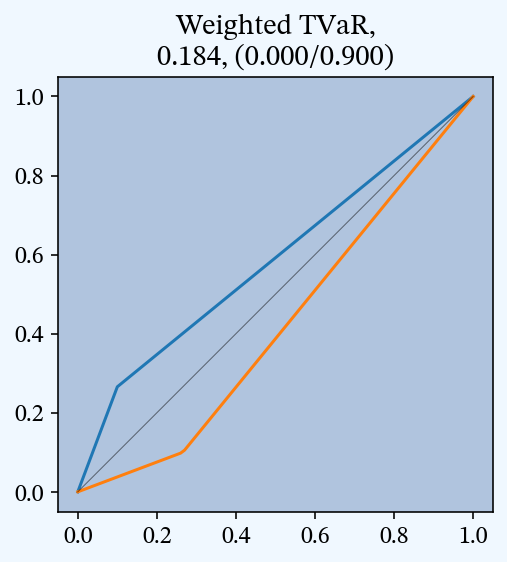

time: 156 ms (started: 2022-09-26 17:57:14 +01:00)


In [54]:
res.port.dists['wtdtvar'].plot()

## Different copulas

Normal vs. t reference distribution.

In [12]:
n = 10000
sample = sam.make_test_sample(n, [100, 100], [0.3, .6])

time: 2.93 ms


In [13]:
rho = -0.5
normal_sample = agg.iman_conover(sample.iloc[:, :2], [[1, rho], [rho, 1]], dof=0)
normal_sample['total'] = normal_sample.sum(axis=1)
normal_sample = normal_sample.sort_index()

t_sample = agg.iman_conover(sample.iloc[:, :2], [[1, rho], [rho, 1]], dof=1.5)
t_sample['total'] = t_sample.sum(axis=1)
t_sample = t_sample.sort_index()

time: 1.01 s


In [14]:
pd.concat((normal_sample.reset_index(drop=True), t_sample.reset_index(drop=True)), axis=1).corr('spearman')

A         B     total         A         B     total
A         1.000 -479.339m  137.155m  112.406m   79.673m  137.155m
B     -479.339m     1.000  741.630m  168.289m  603.306m  741.630m
total  137.155m  741.630m     1.000  250.643m  784.914m     1.000
A      112.406m  168.289m  250.643m     1.000 -271.933m  250.643m
B       79.673m  603.306m  784.914m -271.933m     1.000  784.914m
total  137.155m  741.630m     1.000  250.643m  784.914m     1.000

time: 16.4 ms


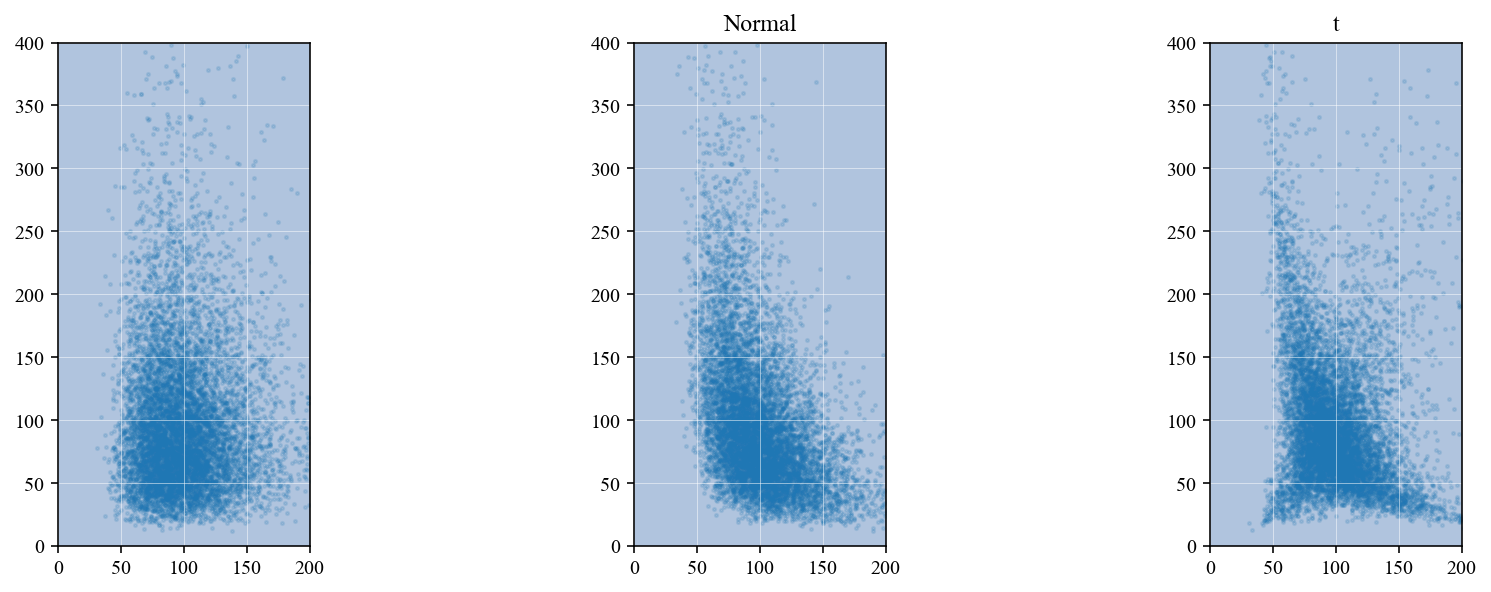

time: 409 ms


In [15]:
%%sf 1 3 4 4 

ax = ax0
ax.scatter(sample.A, sample.B, s=2.5, alpha=.15)
ax.set(xlim=[0, 200], ylim=[0, 400], aspect='equal')
ax.grid(lw=.25, c='w')

ax = ax1
ax.scatter(normal_sample.A, normal_sample.B, s=2.5, alpha=.15)

# bit = normal_sample.query('total > 150')
# ax.scatter(bit.A, bit.B, s=.5, alpha=1, c='C1')

ax.set(xlim=[0, 200], ylim=[0, 400], aspect='equal', title='Normal')
ax.grid(lw=.25, c='w')

ax = ax2
ax.scatter(t_sample.A, t_sample.B, s=2.5, alpha=.15)

# bit = t_sample.query('total > 150')
# ax.scatter(bit.A, bit.B, s=.5, alpha=1, c='C1')

ax.set(xlim=[0, 200], ylim=[0, 400], aspect='equal', title='t')
ax.grid(lw=.25, c='w')

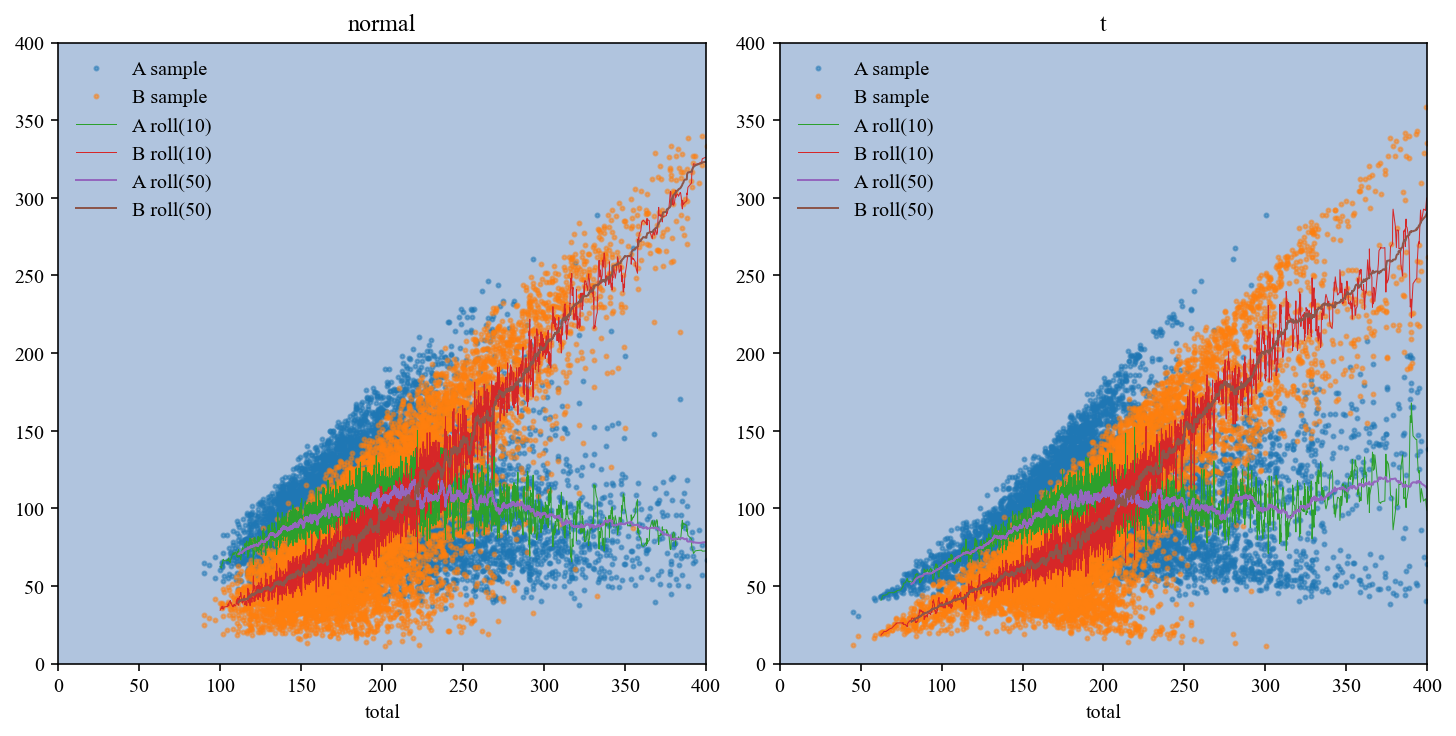

time: 1.29 s


In [18]:
%%sf 1 2 5 5

for ax, csample, title in zip(axs.flat, [normal_sample, t_sample], ['normal', 't']):
    bit = csample.groupby(level='total')[['A', 'B']].agg([np.mean, np.size]).sort_values(
        ('B', 'size'))
    bit = bit.sort_index()
    bit = bit.iloc[:, [0, 2]]
    bit.columns = ['A', 'B']
    
    bit.rename(columns={'A': 'A sample', 'B': 'B sample'}).plot(lw=0, marker='o', ms=2, ax=ax, alpha=.5)

    bit.rolling(10, center=True).mean().rename(columns={'A': 'A roll(10)', 'B': 'B roll(10)'}).\
        plot(lw=.5, ax=ax)
    bit.rolling(100, center=True).mean().rename(columns={'A': 'A roll(50)', 'B': 'B roll(50)'}).\
        plot(lw=1, ax=ax, label=None)

    ax.set(xlim=[0, 400], ylim=[0, 400], title=title)
    ax.legend()
    


In [19]:
from scipy.stats import multivariate_t

time: 916 µs


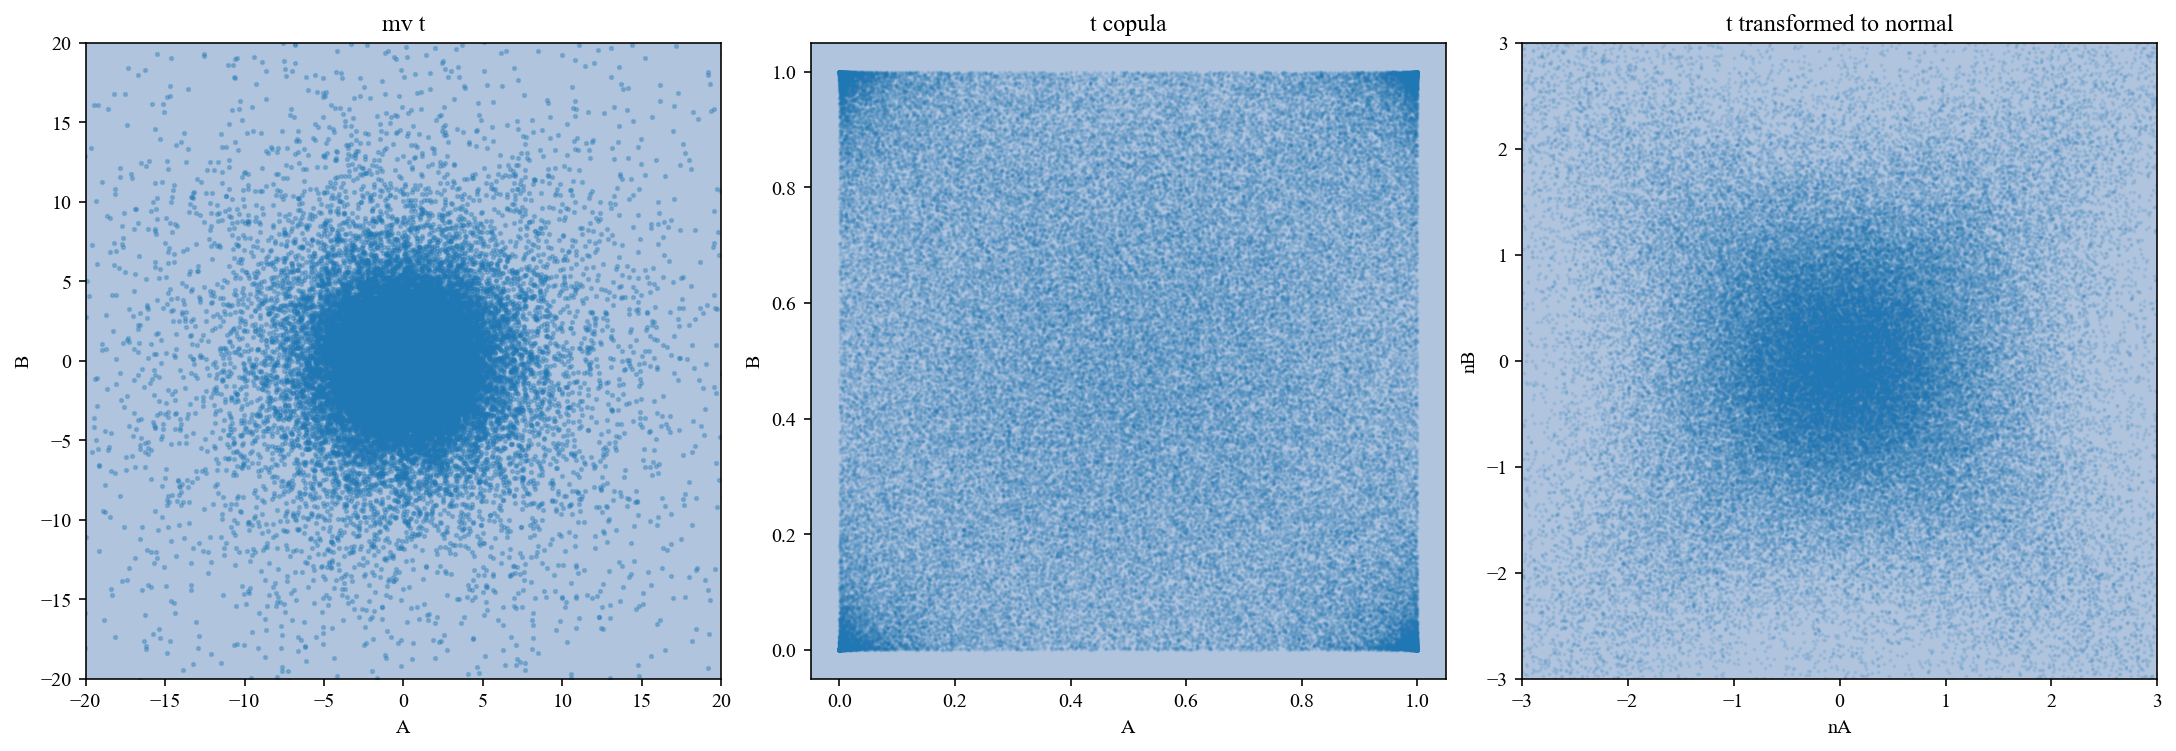

time: 1.1 s


In [20]:
%%sf 1 3 5 5 
rv = multivariate_t([.0, 0], 1, df=1.5) # [[1, 0.5], [0.5, 1]], df=2.5)
t = pd.DataFrame(rv.rvs(100000), columns=['A', 'B'])
t.plot.scatter(x='A', y='B', s=3, alpha=.3, ax=ax0)
ax0.set(aspect='equal', xlim=[-20,20], ylim=[-20,20], title='mv t')

# turn into copula 
F = ss.t.cdf
phiinv = ss.norm.ppf
dof = 3
Ft = F(t, dof)
tf = pd.DataFrame(Ft, columns=['A', 'B'])
tf[['nA', 'nB']] = phiinv(Ft)

tf.plot.scatter(x='A', y='B', s=1, alpha=.1, ax=ax1)
ax1.set(aspect='equal', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title='t copula')

tf.plot.scatter(x='nA', y='nB', s=1, alpha=.1, ax=ax2)
ax2.set(aspect='equal', xlim=[-3, 3], ylim=[-3, 3], title='t transformed to normal')


In [ ]:
|